# Finite Temperature String Method

Umbrella sampling is effective for sampling a well-defined path. In most cases, this also means that the reaction coordinate can be expressed in one (or very few) dimension. However, in (bio)chemical systems, processes are often more complex. It can be challenging to find the stable structures and intermediates, let alone identify the optimal path connecting them.

In this section, we demonstrate the finite temperature string method, which aims to address these problems and iteratively optimises the pathway in a multidimensional space.

Let us get started with the necessary imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from aux import *
from wham import WHAM

## Initial String on a Model potential

In this example, we use a two-dimensional analytical potential. There are two important things regarding the method, which you should remember:
- The number of biased dimensions/colvars can be higher, then the _strings_ will be defined in a $X$-dimensional space.
- You may well be a vast number of other degrees of freedom (for instance if the method is used with classical MD simulations). Selecting the colvars is highly contextual and an important scientific task on its own.

Let us say, we want to find the optimal path connecting the states in (-3,-2) and (3,2). One _string_ will consist of _windows_, similarly to umbrella sampling, and each window will have its biased position in every colvar.

We will sample every window with restraints in place. The strength of the restraints (here again harmonic, typical for distances) again has to be fit for the system, but in general it is *lower* than it would be in umbrella sampling.

In [2]:
""" Parameters """
n_windows = 30  # Number of windows
n_steps = 1000  # Number of steps to run for
T = 300

restraint = np.empty((2, n_windows))    # distances in A
restraint[0] = np.linspace(-3, 3, n_windows)
restraint[1] = np.linspace(-1, 2, n_windows)
force = np.ones((2, n_windows)) * 2     # in kcal/(mol*A^2)

This will simply connect the two starting states by a straight line (in 2D), setting the windows equidistantly.

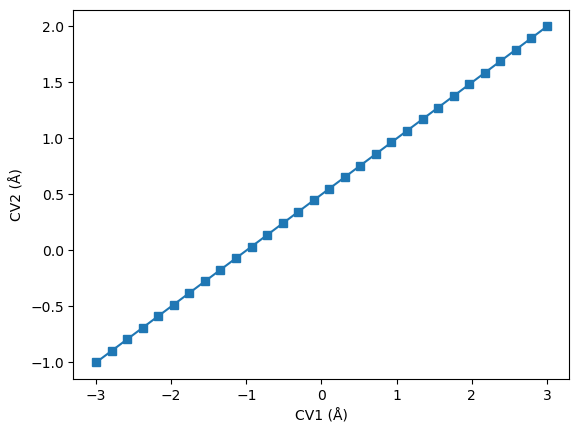

In [3]:
plt.plot(restraint[0], restraint[1], "s-")
plt.xlabel("CV1 (Å)")
plt.ylabel("CV2 (Å)")
plt.show()

## Sampling in Windows

We will start each window from its centre. In this case we use a Monte-Carlo sampler, which drives the system towards lower energy. Here, it is important that the restraints will let each window's sampled population to deviate from the centre. Also, we will need to keep hold of the data we generate and the restraint positions.

In [4]:
# set the starting positions
last_position = np.copy(restraint)
all_data = []
all_restraint = []
# first iteration
data, last_position = generate_data(n_windows, n_steps, T, force, last_position, restraint)
all_data.append(data)
all_restraint.append(restraint)

Take a look at the average position in the simulations. Also, we can plot the data for one of the windows to see where it's been.

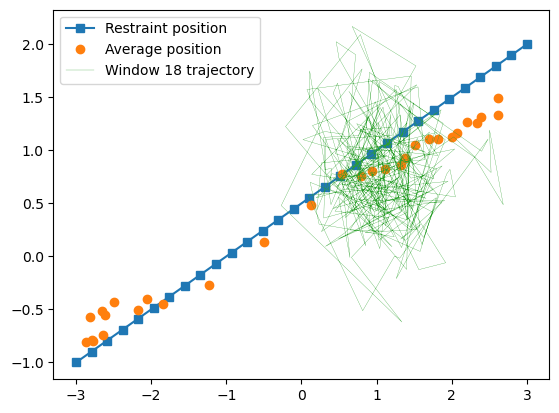

In [5]:
average_position = np.mean(data, axis=1)
plt.plot(restraint[0], restraint[1], "s-", label="Restraint position")
plt.plot(average_position[:, 0], average_position[:, 1], 'o', label="Average position")
window = np.random.randint(0, 29)
plt.plot(data[window, :, 0], data[window, :, 1], label="Window {:d} trajectory".format(window + 1),
        linewidth=0.2)
plt.legend()
plt.show()

## String optimisation

We see the simulations are grouping in different regions and tilt away from out ad-hoc initial string. For the next iteration, we create a new string, by fitting a polynomial to the averages and splitting it again equidistantly. (Other fits are also possible, sometimes beneficial)

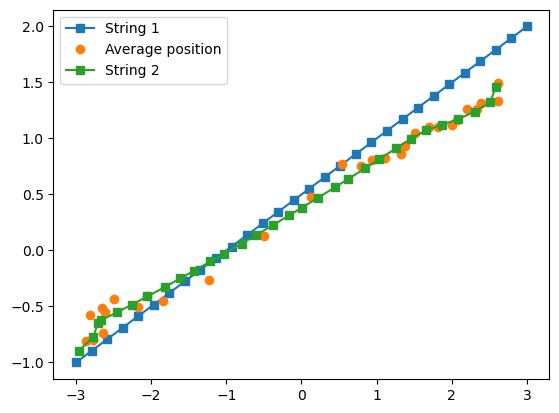

In [6]:
restraint = optimize_string(average_position)

plt.plot(all_restraint[0][0], all_restraint[0][1], "s-", label="String 1")
plt.plot(average_position[:, 0], average_position[:, 1], 'o', label="Average position")
plt.plot(restraint[0], restraint[1], "s-", label="String 2")
plt.legend()
plt.show()

Fast forward some iterations...

In [7]:
niter = 15
for itr in range(niter):
    # Generate stochastic data
    data, last_position = generate_data(n_windows, n_steps, T, force, last_position, restraint)
    all_data.append(data)
    all_restraint.append(restraint)
    average_position = np.mean(data, axis=1)
    # Optimize the string for the next iteration
    restraint = optimize_string(average_position)

Now plot the strings we have so far.

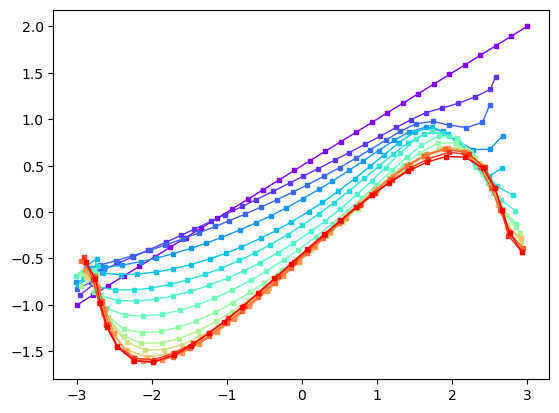

In [8]:
f, ax = plt.subplots()
color = cm.rainbow(np.linspace(0, 1, len(all_restraint)))
for i in range(len(all_restraint)):
    ax.plot(all_restraint[i][0], all_restraint[i][1], "-s", markersize=3, linewidth=1, color=color[i])
plt.show()

## Sampling for the Free Energy Profile

We can see the string starting to converge. On its own, knowing how the colvars change can lead us to some mechanistic insight of the process, but we can aspire for more. With enough sampling along the path, we can reconstruct the underlying potential using WHAM.

In [9]:
niter = 15
for itr in range(niter):
    # Generate stochastic data
    data, last_position = generate_data(n_windows, n_steps, T, force, last_position, restraint)
    all_data.append(data)
    all_restraint.append(restraint)
    average_position = np.mean(data, axis=1)
    # Optimize the string for the next iteration
    restraint = optimize_string(average_position)

## Unbiasing

WHAM will be used similarly to the previous section, which needs some conversion the format.

In [11]:
stride = 3      # may stride the data for saving, to save memory
all_data = np.concatenate(all_data, axis=0)[:, ::stride, :]
all_restraint = np.transpose(np.concatenate(all_restraint, axis=1))

We can skip some of the early strings, which will not contribute much to the profile, but will help us speed up.

In [12]:
skip = 1
w = WHAM()
w.setup(all_data[int(skip * n_windows):], 300,
        np.transpose(np.concatenate([force for _ in range(int(len(all_data) / n_windows) - skip)], axis=1)),
        all_restraint[int(skip * n_windows):])
w.converge(0.01)


0.2
0.2
0.40253258
0.29512668
0.2215054
0.16688108
0.12562656
0.094344854
0.07066107
0.05275941
0.03925228
0.029093027
0.02150011
0.015833378
0.011596918
0.0084126
0.006072521
0.004310608
0.0030305386
0.002801504
0.0027812943
0.0027343072
0.0026826225
0.0026171766
0.0025336705
0.0024577696
0.00237949
0.0022833757
0.0021968558
0.0021200571
0.0020347275
0.0019698776
0.001889348
0.0018201768
0.0017406885
0.0016691722
0.0016027354
0.0015417039
0.0014805477
0.0014230618
0.0013688207
0.0013134126
0.0012522179
0.0012077077
0.0011566747
0.0011152122
0.0010746026
0.0010281932
0.0009791851


/home/berta/PycharmProjects/enhanced-sampling-workshop-2022/Day1/2.String_Method/wham.py:162: RuntimeWarning: divide by zero encountered in log
  self.rUepPerSim = -self.KbT * np.log(PepPersim) - valu
/home/berta/PycharmProjects/enhanced-sampling-workshop-2022/Day1/2.String_Method/wham.py:163: RuntimeWarning: divide by zero encountered in log
  self.rUq2d = -self.KbT * np.log(Pq2d) - valu


Now that we have a converged WHAM, we need to project into a discrete mesh. `[0, 1]` and `[1, 0]` selects the first and second colvars. In a case of a many-dimensional string, we may choose to define linear combinations. 30 is the number of bins.

In [ ]:
w.project_2d([[0, 1], [1, 0]], 30)

## Free Energy Profile

Finally, we can compare the profile with the true potential, access by the Epot function. We jump out to the Qt backend, so the figure can be viewed interactively. We also spice it up with the final string.

In [24]:
%matplotlib qt
# prepare the last string
sx = all_restraint[-n_windows:, 0]
sy = all_restraint[-n_windows:, 1]
sz = Epot(sx, sy)
# we use the internal binning of WHAM
[x, y] = np.meshgrid(w.qspace1, w.qspace2)
fig = plt.figure(figsize=(20, 10))
# start with the true potential
ax_true = fig.add_subplot(121, projection='3d')
surf_true = ax_true.plot_surface(x, y, Epot(x, y), cmap=cm.viridis, vmin=0, vmax=8, zorder=1)
ax_true.plot(sx, sy, sz, "s-", markersize=4, linewidth=2, color="lime", zorder=3)
ax_true.set_zlim(0, 8)
ax_true.view_init(azim=0, elev=90)
# now the reconstruction
ax = fig.add_subplot(122, projection='3d')
surf = ax.plot_surface(x, y, w.rUq2d, cmap=cm.viridis, vmin=0, vmax=8, zorder=1)
ax.plot(sx, sy, sz, "s-", markersize=4, linewidth=2, color="lime", zorder=3)
ax.set_zlim(0, 8)
ax.view_init(azim=0, elev=90)
plt.tight_layout()
plt.show()